In [40]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import ElectraForSequenceClassification, BertTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [41]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#import gluonnlp as nlp
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
device = torch.device("cuda:0")

In [42]:
from transformers import AutoTokenizer
MODEL_NAME= "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

loading configuration file https://huggingface.co/beomi/KcELECTRA-base-v2022/resolve/main/config.json from cache at C:\Users\USER/.cache\huggingface\transformers\677715b0ed32dce9db3091c12047d5d22f03a62eb3aff4b98c408b3d6a3c9211.787019e3fc5c69b1be216b1bd5b640f6cc9d7116635dfd067308d34c42fd1eed
Model config ElectraConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "tokenizer_class": "BertTokenizer",
  "transformers_version": "4.9.0",
  "type_vocab_size": 2,
  "voc

In [43]:
tokenizer

PreTrainedTokenizerFast(name_or_path='beomi/KcELECTRA-base-v2022', vocab_size=54343, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

# Load Koco Dataset

In [44]:
import pandas as pd
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
koco_train_df = pd.read_csv(data_path+"koco_hate_train.txt", sep="\t")
koco_test_df = pd.read_csv(data_path+"koco_hate_test.txt", sep="\t")
koco_train_df.head(5)

,comments,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,2
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",2
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,2


In [45]:
tokenized_train_sentences = tokenizer(
                            list(koco_train_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

tokenized_test_sentences = tokenizer(
                            list(koco_test_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

In [46]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [47]:
train_label = koco_train_df["hate"].values
test_label =  koco_test_df["hate"].values

train_dataset = MyDataset(tokenized_train_sentences, train_label)
test_dataset = MyDataset(tokenized_test_sentences, test_label)

# 모델 튜닝

In [48]:
from coral_pytorch.layers import CoralLayer
from coral_pytorch.losses import CoralLoss
from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.dataset import proba_to_label

In [49]:
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.to(device)

loading configuration file https://huggingface.co/beomi/KcELECTRA-base-v2022/resolve/main/config.json from cache at C:\Users\USER/.cache\huggingface\transformers\677715b0ed32dce9db3091c12047d5d22f03a62eb3aff4b98c408b3d6a3c9211.787019e3fc5c69b1be216b1bd5b640f6cc9d7116635dfd067308d34c42fd1eed
Model config ElectraConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "s

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [50]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/', # 학습결과 저장경로
    num_train_epochs=10,                # 학습 epoch 설정
    per_device_train_batch_size=4,      # train batch_size 설정
    per_device_eval_batch_size=32,      # test batch_size 설정
    logging_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/logs/',# 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [51]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [52]:
from transformers import Trainer
#model_path = 'C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/pytorch_model.bin'
#model.load_state_dict(torch.load(model_path))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [53]:
trainer.train()

***** Running training *****
  Num examples = 7896
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 19740
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss
500,0.939300
1000,0.854600
1500,0.817000
2000,0.795700
2500,0.685500
3000,0.706800
3500,0.705900
4000,0.714700
4500,0.552500
5000,0.564000


Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcELECTRA_outputs\output\checkpoint-19000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-1000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-1000\co

Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcELECTRA_outputs\output\checkpoint-4500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-6000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-6000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-6000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcELECTRA_outputs\output\checkpoint-5000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_l

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-11000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-11000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-11000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcELECTRA_outputs\output\checkpoint-10000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-11500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-

Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcELECTRA_outputs\output\checkpoint-15000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-16500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-16500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/checkpoint-16500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcELECTRA_outputs\output\checkpoint-15500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipyker

TrainOutput(global_step=19740, training_loss=0.3319643473311157, metrics={'train_runtime': 1266.122, 'train_samples_per_second': 62.364, 'train_steps_per_second': 15.591, 'total_flos': 2596929432975360.0, 'train_loss': 0.3319643473311157, 'epoch': 10.0})

In [54]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'eval_loss': 2.9913086891174316,
 'eval_accuracy': 0.6836518046709129,
 'eval_f1': 0.6821137679143275,
 'eval_precision': 0.6965664956058092,
 'eval_recall': 0.686256216208402,
 'eval_runtime': 0.4019,
 'eval_samples_per_second': 1171.862,
 'eval_steps_per_second': 37.32,
 'epoch': 10.0}

In [55]:
trainer.save_model()

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcELECTRA_outputs/output/pytorch_model.bin


In [61]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


              precision    recall  f1-score   support

           0       0.67      0.89      0.77       160
           1       0.64      0.55      0.59       189
           2       0.77      0.61      0.68       122

    accuracy                           0.68       471
   macro avg       0.70      0.69      0.68       471
weighted avg       0.69      0.68      0.68       471



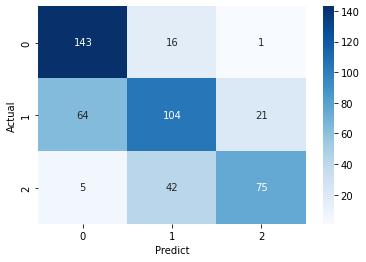

In [63]:
## classification_report
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = torch.tensor(predictions.predictions).argmax(-1)
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [58]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [64]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.3291)
tensor(0.3546)


C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [26]:
from scipy import special
import pandas as pd

def custom_proba_to_label(probas, first_threshold, second_threshold):
    predict_levels = pd.DataFrame(probas)
    class_O = predict_levels[0].apply(lambda x: x > first_threshold)
    class_H = predict_levels[1].apply(lambda x: x > second_threshold)
    labels_v3 = pd.concat([class_O, class_H], axis=1)
    labels_v3 = labels_v3.sum(axis=1)
    return labels_v3

In [27]:
predicts_threshold = custom_proba_to_label(predictions.predictions.tolist(), 0.3, 0.7)

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       160
           1       0.45      0.89      0.60       189
           2       0.00      0.00      0.00       122

    accuracy                           0.36       471
   macro avg       0.15      0.30      0.20       471
weighted avg       0.19      0.36      0.24       471



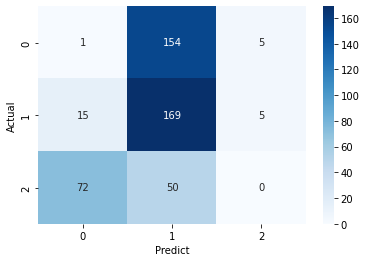

In [28]:
## classification_report
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = predicts_threshold
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [29]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.8025)
tensor(1.1295)


In [30]:
predictions

PredictionOutput(predictions=array([[ 7.538086 , -3.685877 , -4.024938 ],
       [-3.9417264,  7.1240644, -3.1867533],
       [-3.8662367,  7.1641326, -3.2961547],
       ...,
       [-2.6590989,  6.3261714, -3.6829114],
       [-2.8966217, -3.6234658,  5.982377 ],
       [-3.5727093,  6.4556785, -2.8588383]], dtype=float32), label_ids=array([0, 1, 2, 2, 1, 2, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 0,
       1, 2, 2, 0, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1,
       0, 1, 2, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 2, 1, 1, 0, 2, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 2, 1, 2, 2, 1, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0,
       2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 0, 1,
       1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 2, 2,
       1, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1,
     

In [150]:
from torchsummary import summary as summary
summary(model, (4, 54343))

ValueError: too many values to unpack (expected 2)

In [155]:
count = 0
for name, param in model.named_parameters():
    count+=1
    if count==1:
        print(param.size())
        print(name)

torch.Size([54343, 768])
electra.embeddings.word_embeddings.weight
